In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.pipeline import Pipeline
import joblib
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score

#### Loading the dataset

In [2]:
directory_path = 'Dataset/new_feature_csv'
regular_data = []
attack_data = []
for subfolder in os.listdir(directory_path):
    subfolder_path = os.path.join(directory_path, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".csv"):
                file_path = os.path.join(subfolder_path, filename)
                df = pd.read_csv(file_path)
                if subfolder == 'Regular':
                    df['Label'] = -1
                    regular_data.append(df)
                else:
                    df['Label'] = +1
                    attack_data.append(df)
all_regular_raw_data = pd.concat(regular_data, ignore_index=True)
all_attack_raw_data = pd.concat(attack_data, ignore_index=True)

#### Data Preprocessing

In [4]:
all_regular_data_sh=shuffle(all_regular_raw_data, random_state=42)
all_attack_data_sh=shuffle(all_attack_raw_data, random_state=42)

In [5]:
X_train_regular, X_remaining_regular = train_test_split(all_regular_data_sh, test_size=0.40, random_state=42)
X_validation_regular, X_test_regular = train_test_split(X_remaining_regular, test_size=0.50, random_state=42)
X_validation_attack, X_remaining_attack = train_test_split(all_attack_data_sh, test_size=0.80, random_state=42)
X_validation_combined = pd.concat([X_validation_regular, X_validation_attack], ignore_index=True)
X_validation_combined_sh = shuffle(X_validation_combined, random_state=42)
X_test_combined = pd.concat([X_test_regular, X_remaining_attack], ignore_index=True)
X_test_combined_sh = shuffle(X_test_combined, random_state=42)

#### Imputation and Normalization

In [6]:
y_tr=X_train_regular["Label"]
y_va=X_validation_combined_sh["Label"]
y_te=X_test_combined_sh["Label"]
X_tr = X_train_regular.drop('Label', axis=1)
X_va = X_validation_combined_sh.drop('Label', axis=1)
X_te = X_test_combined_sh.drop('Label', axis=1)

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))
])

In [8]:
X_train = pipeline.fit_transform(X_tr)
X_validation = pipeline.transform(X_va)
X_test = pipeline.transform(X_te)

#### Tuning Process

In [13]:
pca_components = [0.80, 0.90, 0.95]
results = {}

for component in pca_components:
    pca = PCA(n_components=component)
    lof_pca = LocalOutlierFactor(n_neighbors=10, novelty=True)
    X_train_pca = pca.fit_transform(X_train)
    X_validation_pca = pca.transform(X_validation)
    lof_pca.fit(X_train_pca)
    X_pred_val_pca=-lof_pca.predict(X_validation_pca)
    score = f1_score(y_va,X_pred_val_pca)
    results[component] = score

best_component = max(results, key=results.get)
best_score = results[best_component]

print(f"Best PCA component ratio: {best_component}")
print(f"Best F1 Score: {best_score}")

Best PCA component ratio: 0.9
Best F1 Score: 0.9850428246914764


In [15]:
pca_tr=PCA(n_components=best_component)
X_train_pca=pca_tr.fit_transform(X_train)
X_validation_pca = pca_tr.transform(X_validation)
X_test_pca = pca_tr.transform(X_test)

In [16]:
param_grid = {
    'n_neighbors': [10, 20, 30, 40],
    'contamination': [0.01, 0.05, 0.1, 0.2]
}
best_params = None
best_f1 = -1
best_model = None
for n_neighbors in param_grid['n_neighbors']:
    for contamination in param_grid['contamination']:
        lof = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True
        )
        lof.fit(X_train_pca)
        val_predictions = -lof.predict(X_validation_pca)
        f1 = f1_score(y_va, val_predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_params = {
                'n_neighbors': n_neighbors,
                'contamination': contamination
            }
            best_model = lof
print(f'Best Parameters: {best_params}')
print(f'Best F1 Score: {best_f1}')
best_filename = f"best_local_outlier_factor_{best_params['n_neighbors']}_{best_params['contamination']}.pkl"
joblib.dump(best_model, best_filename)
print(f'Best model saved as {best_filename}')


Best Parameters: {'n_neighbors': 10, 'contamination': 0.01}
Best F1 Score: 0.9882423513488665
Best model saved as best_local_outlier_factor_10_0.01.pkl


#### Examine The Result

##### Loading Pre-trained Model

In [17]:
best_model_filename = best_filename
best_model = joblib.load(best_model_filename)

##### Cross-Validation

In [18]:
pipeline_lof= Pipeline([
    ('pca', PCA(n_components=best_component)),
    ('lof', best_model)
])
cv_scores = cross_val_score(pipeline_lof, X_train_pca, -y_tr, cv=5, scoring='f1', n_jobs=-1)
print(f'Cross-Validation F1 Scores: {cv_scores}')
print(f'Mean Cross-Validation F1 Score: {cv_scores.mean()}')

Cross-Validation F1 Scores: [0.99492223 0.99467899 0.99487294 0.99486633 0.99495177]
Mean Cross-Validation F1 Score: 0.9948584516481244


##### Learning Curve Plot

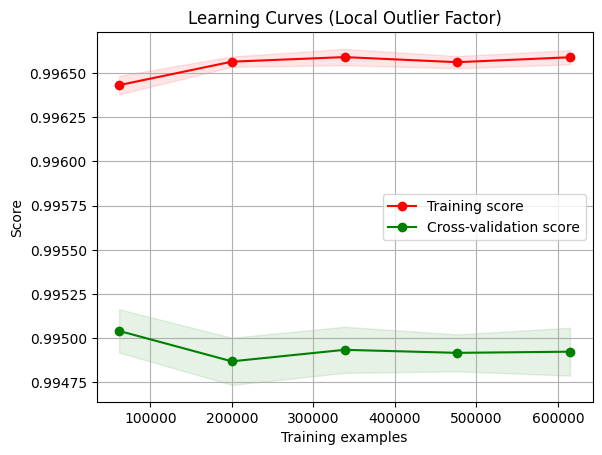

In [19]:
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train_pca, -y_tr, cv=5, scoring='f1', n_jobs=-1)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure()
plt.title("Learning Curves (Local Outlier Factor)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


#### Performance Evaluation Metrics

Accuracy: 0.9867599461640164
Precision: 0.9921077079973006
Recall: 0.9844069974837404
F1 Score: 0.9882423513488665
ROC AUC: 0.987112989964256
Confusion Matrix:
[[327841   5193]
 [  2608 253555]]


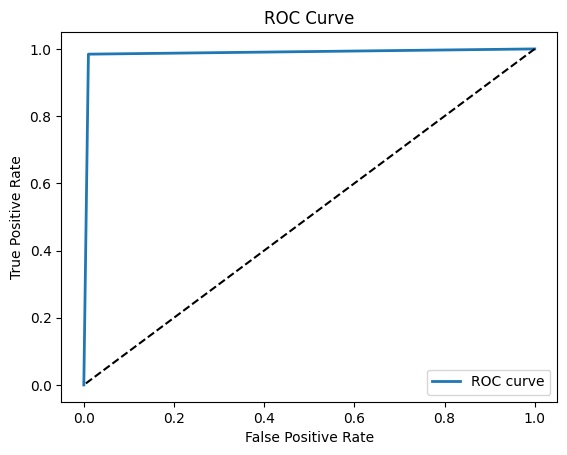

In [20]:
y_va_pred = -best_model.predict(X_validation_pca)

accuracy = accuracy_score(y_va, y_va_pred)
precision = precision_score(y_va, y_va_pred)
recall = recall_score(y_va, y_va_pred)
f1 = f1_score(y_va, y_va_pred)
roc_auc = roc_auc_score(y_va, y_va_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

conf_matrix = confusion_matrix(y_va, y_va_pred,labels=[1,-1])
print('Confusion Matrix:')
print(conf_matrix)


fpr, tpr, thresholds = roc_curve(y_va, y_va_pred)
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([1, 0], [1, 0], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()